## Nick Murphy (nmurph03)
## Project 1 Code

## HW03 Code


You will complete the following notebook, as described in the PDF for Homework 03 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.


Please report any questions to the [class Piazza page](piazza.com/tufts/spring2021/comp135/home).

### Import required libraries

In [2]:
import os
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sklearn.linear_model
import sklearn.metrics
from sklearn.linear_model import LogisticRegression

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

Cancer-Risk Screening

### 1: Compute true/false positives/negatives.

Complete the following code.

In [3]:
def calc_TP_TN_FP_FN(ytrue_N, yhat_N):
    ''' Compute counts of four possible outcomes of a binary classifier for evaluation.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yhat_N : 1D array of floats
        Each entry represents a predicted binary value (either 0 or 1).
        One entry per example in current dataset.
        Needs to be same size as ytrue_N.

    Returns
    -------
    TP : float
        Number of true positives
    TN : float
        Number of true negatives
    FP : float
        Number of false positives
    FN : float
        Number of false negatives
    '''
    TP = 0.0
    TN = 0.0
    FP = 0.0
    FN = 0.0
    for i in range(len(ytrue_N)):
        if yhat_N[i] == 1:
            if ytrue_N[i] == yhat_N[i]:
                TP+=1
            elif ytrue_N[i] != yhat_N[i]:
                FP+=1
        elif yhat_N[i] == 0:
            if ytrue_N[i] == yhat_N[i]:
                TN+=1
            elif ytrue_N[i] != yhat_N[i]:
                FN+=1
    return TP, TN, FP, FN

In [4]:
all0 = np.zeros(10)
all1 = np.ones(10)
calc_TP_TN_FP_FN(all0, all1)

(0.0, 0.0, 10.0, 0.0)

In [5]:
calc_TP_TN_FP_FN(all1, all0)

(0.0, 0.0, 0.0, 10.0)

In [6]:
calc_TP_TN_FP_FN(all1, all1)

(10.0, 0.0, 0.0, 0.0)

In [7]:
calc_TP_TN_FP_FN(all0, all0)

(0.0, 10.0, 0.0, 0.0)

### Supplied functions for later use

***Do not*** edit the following functions.  They are already complete, and will be used in your later code.

In [8]:
def calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute performance metrics for a given probabilistic classifier and threshold
    '''
    tp, tn, fp, fn = calc_TP_TN_FP_FN(ytrue_N, yproba1_N >= thresh)
    ## Compute ACC, TPR, TNR, etc.
    acc = (tp + tn) / float(tp + tn + fp + fn + 1e-10)
    tpr = tp / float(tp + fn + 1e-10)
    tnr = tn / float(fp + tn + 1e-10)
    ppv = tp / float(tp + fp + 1e-10)
    npv = tn / float(tn + fn + 1e-10)
    
    return acc, tpr, tnr, ppv, npv

def print_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Pretty print perf. metrics for a given probabilistic classifier and threshold
    '''
    acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
    
    ## Pretty print the results
    print("%.3f ACC" % acc)
    print("%.3f TPR" % tpr)
    print("%.3f TNR" % tnr)
    print("%.3f PPV" % ppv)
    print("%.3f NPV" % npv)

In [9]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute the confusion matrix for a given probabilistic classifier and threshold
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
        Needs to be same size as ytrue_N
    thresh : float
        Scalar threshold for converting probabilities into hard decisions
        Calls an example "positive" if yproba1 >= thresh

    Returns
    -------
    cm_df : Pandas DataFrame
        Can be printed like print(cm_df) to easily display results
    '''
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

In [10]:
def compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N, thresh_grid=None):
    ''' Compute common binary classifier performance metrics across many thresholds
    
    If no array of thresholds is provided, will use all 'unique' values
    in the yproba1_N array to define all possible thresholds with different performance.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset

    Returns
    -------
    thresh_grid : 1D array of floats
        One entry for each possible threshold
    perf_dict : dict, with key, value pairs:
        * 'acc' : 1D array of accuracy values (one per threshold)
        * 'ppv' : 1D array of positive predictive values (one per threshold)
        * 'npv' : 1D array of negative predictive values (one per threshold)
        * 'tpr' : 1D array of true positive rates (one per threshold)
        * 'tnr' : 1D array of true negative rates (one per threshold)
    '''
    if thresh_grid is None:
        bin_edges = np.linspace(0, 1.001, 21)
        thresh_grid = np.sort(np.hstack([bin_edges, np.unique(yproba1_N)]))
    tpr_grid = np.zeros_like(thresh_grid)
    tnr_grid = np.zeros_like(thresh_grid)
    ppv_grid = np.zeros_like(thresh_grid)
    npv_grid = np.zeros_like(thresh_grid)
    acc_grid = np.zeros_like(thresh_grid)
    for tt, thresh in enumerate(thresh_grid):
        # Apply specific threshold to convert probas into hard binary values (0 or 1)
        # Then count number of true positives, true negatives, etc.
        # Then compute metrics like accuracy and true positive rate
        acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
        acc_grid[tt] = acc
        tpr_grid[tt] = tpr
        tnr_grid[tt] = tnr
        ppv_grid[tt] = ppv
        npv_grid[tt] = npv
    return thresh_grid, dict(
        acc=acc_grid,
        tpr=tpr_grid,
        tnr=tnr_grid,
        ppv=ppv_grid,
        npv=npv_grid)

def make_plot_perf_vs_threshold(ytrue_N, yproba1_N, bin_edges=np.linspace(0, 1, 21)):
    ''' Make pretty plot of binary classifier performance as threshold increases
    
    Produces a plot with 3 rows:
    * top row: hist of predicted probabilities for negative examples (shaded red)
    * middle row: histogram of predicted probabilities for positive examples (shaded blue)
    * bottom row: line plots of metrics that require hard decisions (ACC, TPR, TNR, etc.)
    
    The two histograms are as follows:
    * The first (red) shows the number of class-0 entries, grouped by 
      the probabilities assigned by the predictor (yproba1_N).
    * The second (blue) shows the number of class-1 entries, grouped by
      the probabilities assigned by the predictor (yproba1_N).
    
    A "perfect" classifier would assign everything in class 0 the probability 0.0, 
    and everything in class 1 the probability 1.0, and the histograms would look 
    like one big pile of 150 items at 0.0, and then 25 items at 1.0.  
    
    You can actually see what this would look like by calling:
        make_plot_perf_vs_threshold(y_va_N, y_va_N)
    
    Note that we of course don't expect perfect (0.0/1.0) predictions, but we can 
    still get a "perfect" probabilistic classifier if we have a threshold point T 
    where all the 0-class stuff from the first histogram is below T, and all the 
    1-class stuff from the second one is at or above T.  Of course, we probably 
    can't get that either, since complex data may not be linearly separable at all, 
    but that's the goal.
    '''
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
    sns.distplot(
        yproba1_N[ytrue_N == 0],
        color='r', bins=bin_edges, kde=False, rug=True, ax=axes[0]);
    sns.distplot(
        yproba1_N[ytrue_N == 1],
        color='b', bins=bin_edges, kde=False, rug=True, ax=axes[1]);

    thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N)
    axes[2].plot(thresh_grid, perf_grid['acc'], 'k-', label='accuracy')
    axes[2].plot(thresh_grid, perf_grid['tpr'], 'b-', label='TPR (recall/sensitivity)')
    axes[2].plot(thresh_grid, perf_grid['tnr'], 'g-', label='TNR (specificity)')
    axes[2].plot(thresh_grid, perf_grid['ppv'], 'c-', label='PPV (precision)')
    axes[2].plot(thresh_grid, perf_grid['npv'], 'm-', label='NPV')
    
    axes[2].legend()
    axes[2].set_ylim([0, 1])

### Load the dataset.

The following should ***not*** be modified.  After it runs, the various arrays it creates will contain the 2- or 3-feature input datasets.

In [11]:
# Load 3 feature version of x arrays
x_tr_M3 = np.loadtxt('./data_cancer/x_train.csv', delimiter=',', skiprows=1)
x_va_N3 = np.loadtxt('./data_cancer/x_valid.csv', delimiter=',', skiprows=1)
x_te_N3 = np.loadtxt('./data_cancer/x_test.csv', delimiter=',', skiprows=1)

# 2 feature version of x arrays
x_tr_M2 = x_tr_M3[:, :2].copy()
x_va_N2 = x_va_N3[:, :2].copy()
x_te_N2 = x_te_N3[:, :2].copy()

In [12]:
y_tr_M = np.loadtxt('./data_cancer/y_train.csv', delimiter=',', skiprows=1)
y_va_N = np.loadtxt('./data_cancer/y_valid.csv', delimiter=',', skiprows=1)
y_te_N = np.loadtxt('./data_cancer/y_test.csv', delimiter=',', skiprows=1)

### 2: Compute the fraction of patients with cancer.

Complete the following code.  Your solution needs to ***compute*** these values from the training, validation, and testing sets (i.e., don't simply hand-count and print the values).

In [13]:
def frac_with_cancer(dataset):
    l = len(dataset)
    s = sum(dataset)
    r = s/l
    return r

In [14]:
print("Fraction with cancer in TRAIN: %.3f" % frac_with_cancer(y_tr_M)) #TODO: modify what is printed here.
print("Fraction with cancer in VALID: %.3f" % frac_with_cancer(y_va_N))
print("Fraction with cancer in TEST : %.3f" % frac_with_cancer(y_te_N))

Fraction with cancer in TRAIN: 0.141
Fraction with cancer in VALID: 0.139
Fraction with cancer in TEST : 0.139


### 3: The predict-0-always baseline

#### (a) Compute the accuracy of the always-0 classifier.

Complete the code to compute and print the accuracy of the always-0 classifier on validation and test outputs.

In [15]:
def accuracy(data, checker):
    TP, TN, FP, FN = calc_TP_TN_FP_FN(data, checker)
    acc = float((TP + TN)/(TP + TN + FP + FN))
    return acc

In [16]:
val_zeroes = np.zeros(len(y_va_N))
val_acc = accuracy(y_va_N, val_zeroes)

test_zeroes = np.zeros(len(y_te_N))
test_acc = accuracy(y_te_N, test_zeroes)

In [17]:
print("Always-0: accuracy on VALID: %.3f" % val_acc) # TODO edit values!
print("Always-0: accuracy on TEST : %.3f" % test_acc)

Always-0: accuracy on VALID: 0.861
Always-0: accuracy on TEST : 0.861


#### (b) Print a confusion matrix for the always-0 classifier.

Add code below to generate a confusion matrix for the always-0 classifier on the validation set.

In [18]:
calc_confusion_matrix_for_threshold(y_va_N, val_zeroes, 0.5)

Predicted,0,1
True,,
0,155,0
1,25,0


#### (c) Reflect on the accuracy of the always-0 classifier.

**Answer**: The accuracy of the always-0 classifier came out to be around 86%, which does not look bad. Given the circumstances and data, however, 86% could be interpretted as quite bad. Based on the confusion matrix, 25 out of 180 people were incorrectly labeled as not having cancer. Misdiagnosing someone as not having cancer could kill, so 86% is not good enough. We care more about positive diagnoses, so using an always-0 classifier doesn't make sense in this situation. We can't calculate any statistics to determine the accuracy of our model based on this classifier (no true positive value or false positive value.)

#### (d) Analyze the various costs of using the always-0 classifier.


**Answer**: The biggest cost of using the always-0 classifier is that it focuses on people that don't have cancer. Society pays more attention to people who have cancer, which doesn't align with this model.  Using an always-0 classifier brings too many false positives, and we'd prefer to see more false negatives because that would hopefully mean we are detecting some patients with cancer. Using this classifier would cost a lot of patients a lot of money, physical and emotional exhaustian, and time in the hospital. I would recommend using an always-1 classifier, because then at least you are detecting some patients with cancer. It might end up being less accurate on all patients but a false positive is less costly than a false negative. 

### 4: Logistic Regression

#### (a) Create a set of `LogisticRegression` models.

Each model will use a different control parameter, `C`, and each will be fit to 2-feature data.  Probabilistic predictions will be made on both training set and validation set inputs, and logistic-loss for each will be recorded.

In [62]:
tr_loss_list = list()
va_loss_list = list()

# TODO fit, predict_proba, and evaluate logistic loss    
# Record the best model here
def calc_log_loss(C, x_va, x_tr, y_va, y_tr):
    model = LogisticRegression(C=C, solver='liblinear').fit(x_tr, y_tr)
    tr_predict = model.predict_proba(x_tr)
    va_predict = model.predict_proba(x_va)
    tr_loss = sklearn.metrics.log_loss(y_tr, tr_predict)
    va_loss = sklearn.metrics.log_loss(y_va, va_predict)
    return tr_loss, va_loss

In [63]:
C = np.logspace(-9,6,31)
tr_losses_2 = list()
va_losses_2 = list() 
for j in C:
    tr_loss, va_loss = calc_log_loss(j, x_va_N2, x_tr_M2, y_va_N, y_tr_M)
    tr_losses_2.append(tr_loss)
    va_losses_2.append(va_loss)

#### Plot logistic loss (y-axis) vs. C (x-axis) on the training set and validation set.

The best values for `C` and the loss should be printed.

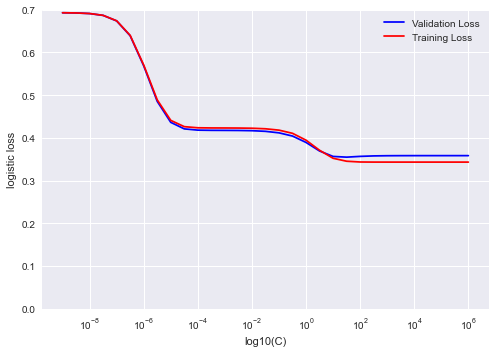

Best C-value for LR with 2-feature data: 31.623
Validation set log-loss at best C-value: 0.3549


In [64]:
# TODO make plot
plt.xscale('log')
plt.xlabel('log10(C)')
plt.ylabel('logistic loss')
plt.plot(C,va_losses_2, color='blue',label = "Validation Loss")
plt.plot(C,tr_losses_2, color='red',label = "Training Loss")
plt.ylim([0.0, 0.7]);
# TODO add legend
# plt.legend(...);
plt.legend()
plt.show()
print("Best C-value for LR with 2-feature data: %.3f" % C[np.argmin(va_losses_2)]) # TODO
print("Validation set log-loss at best C-value: %.4f" % min(va_losses_2))

#### (b) Plot the performance of the predictions made by the best classifier from step (a) on the validation set.

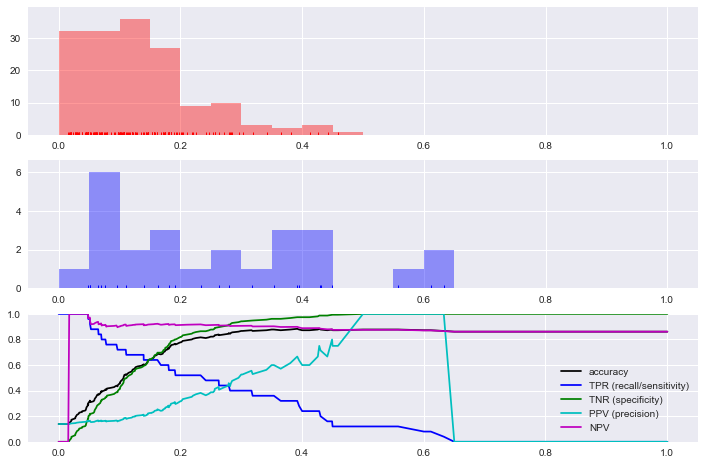

In [65]:
# TODO call make_plot_perf_vs_threshold(...)
best_C2 = C[np.argmin(va_losses_2)]
bestmodel = LogisticRegression(C = best_C2, solver = 'liblinear').fit(x_tr_M2, y_tr_M)
y_proba = bestmodel.predict_proba(x_va_N2)[:,1]
make_plot_perf_vs_threshold(y_va_N, y_proba)

#### (c) Model fitting with 3-feature data

Repeat the model generation from **1.4 (a)**, using the full 3-feature data.

In [67]:
# TODO like 1.4 (a), but with 3 features
tr_losses_3 = list()
va_losses_3 = list()
C = np.logspace(-9,6,31)
for p in C:
    tr_loss_3, va_loss_3 = calc_log_loss(p, x_va_N3, x_tr_M3, y_va_N, y_tr_M)
    tr_losses_3.append(tr_loss_3)
    va_losses_3.append(va_loss_3)

#### Plot logistic loss (y-axis) vs. C (x-axis) for the 3-feature classifiers on the training set and validation set.

Again, the best values for `C` and the loss should be printed.

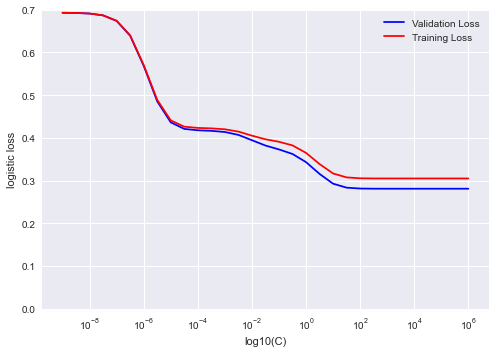

Best C-value for LR with 3-feature data: 1000000.000
Validation set log-loss at best C-value: 0.2810


In [68]:
# TODO make plot
plt.xscale('log')
plt.xlabel('log10(C)')
plt.ylabel('logistic loss')
plt.plot(C, va_losses_3, color = 'blue', label = 'Validation Loss')
plt.plot(C, tr_losses_3, color = 'red', label = 'Training Loss')
plt.ylim([0.0, 0.7]);

# TODO add legend
plt.legend()
plt.show()

print("Best C-value for LR with 3-feature data: %.3f" % C[np.argmin(va_losses_3)]) # TODO
print("Validation set log-loss at best C-value: %.4f" % min(va_losses_3))

#### Plot the performance of the predictions made by the best 3-valued classifier on the validation set.

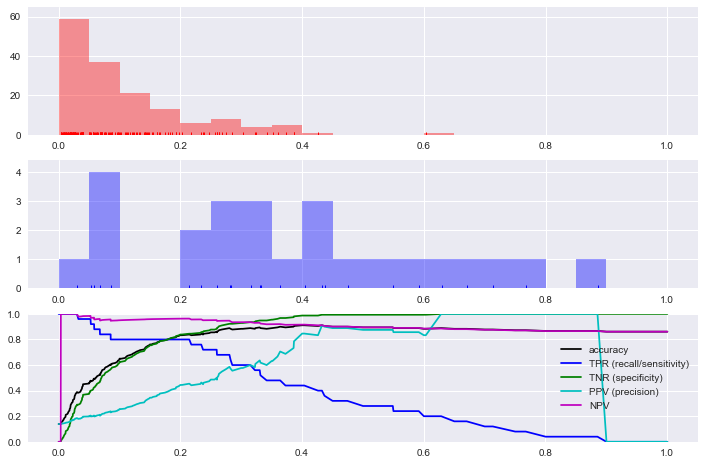

In [69]:
# TODO call make_plot_perf_vs_threshold(...)
best_C3 = C[np.argmin(va_losses_3)]
bestmodel = LogisticRegression(C = best_C3, solver = 'liblinear').fit(x_tr_M3, y_tr_M)
y_prob_3 = bestmodel.predict_proba(x_va_N3)[:,1]
make_plot_perf_vs_threshold(y_va_N, y_prob_3)

### 5: ROC Curves

These curves allow us to compare model performance in terms of trade-offs between false positive and true positive results.

#### (a) Plot ROC curves on the validation set.

There should be two curves in the plot, one for each of the best two classifiers from prior steps.

In [70]:
vamodel2 = LogisticRegression(C = best_C2, solver = 'liblinear').fit(x_tr_M2, y_tr_M)
y_prob_2 = vamodel2.predict_proba(x_va_N2)[:,1]
fpr_2, tpr_2, thresh_va_2 = sklearn.metrics.roc_curve(y_va_N, y_prob_2)

In [71]:
vamodel3 = LogisticRegression(C = best_C3, solver = 'liblinear').fit(x_tr_M3, y_tr_M)
y_prob_3 = vamodel3.predict_proba(x_va_N3)[:,1]
fpr_3, tpr_3, thresh_va_3 = sklearn.metrics.roc_curve(y_va_N, y_prob_3)

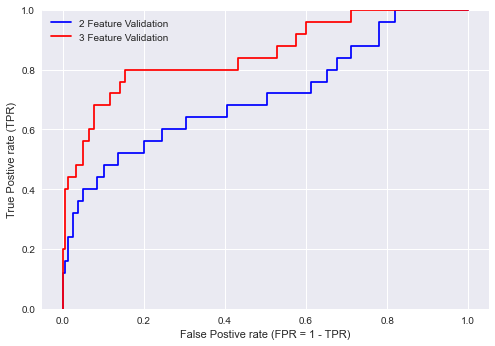

In [72]:
# TODO something like: fpr, tpr, thr = sklearn.metrics.roc_curve(...)

plt.ylim([0, 1]);
plt.plot(fpr_2,tpr_2, color = 'blue', label = '2 Feature Validation')
plt.plot(fpr_3, tpr_3, color = 'red', label = '3 Feature Validation')
plt.xlabel("False Postive rate (FPR = 1 - TPR)");
plt.ylabel("True Postive rate (TPR)");
plt.legend()
plt.show()

#### (b) Plot ROC curves on the test set.

There should be two curves in the plot, one for each of the best two classifiers from prior steps.

In [73]:
temodel2 = LogisticRegression(C = best_C2, solver = 'liblinear').fit(x_tr_M2, y_tr_M)
te_y_prob_2 = temodel2.predict_proba(x_te_N2)[:,1]
te_fpr_2, te_tpr_2, thresh_te_2 = sklearn.metrics.roc_curve(y_te_N, te_y_prob_2)

In [74]:
temodel3 = LogisticRegression(C = best_C3, solver = 'liblinear').fit(x_tr_M3, y_tr_M)
te_y_prob_3 = temodel3.predict_proba(x_te_N3)[:,1]
te_fpr_3, te_tpr_3, thresh_te_3 = sklearn.metrics.roc_curve(y_te_N, te_y_prob_3)

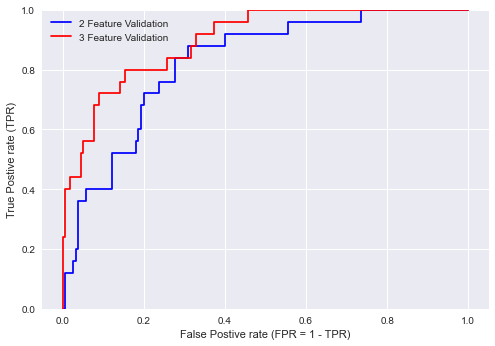

In [75]:
# TODO something like: fpr, tpr, thr = sklearn.metrics.roc_curve(...)

plt.ylim([0, 1]);
plt.plot(te_fpr_2,te_tpr_2, color = 'blue', label = '2 Feature Validation')
plt.plot(te_fpr_3, te_tpr_3, color = 'red', label = '3 Feature Validation')
plt.xlabel("False Postive rate (FPR = 1 - TPR)");
plt.ylabel("True Postive rate (TPR)");
plt.legend()
plt.show()

#### (c) Analyze the results shown in both the above plots, to compare classifier performance.

**Answer**: For a majority of instances, the 3 feature classifier performs better than the 2 feature classifier on both testing and validation sets. The 3 feature classifier has a greater area under the curve, as well as hitting the TPR = 1 line 'earlier'. On the other hand, the 2 feature classifier has a smaller area under the curve as well as hitting the TPR = 1 line 'later'. 

### 6: Selecting a decision threshold

#### (a) Using default 0.5 threshold. 

Generate a confusion matrix for the best 3-feature logistic model on the test set, using threshold 0.5.

In [76]:
best_thr = 0.5
temodel3 = LogisticRegression(C = best_C3, solver = 'liblinear').fit(x_tr_M3, y_tr_M)
te_y_prob_3 = temodel3.predict_proba(x_te_N3)[:,1]
print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(y_te_N, te_y_prob_3, best_thr))
print("")
print(print_perf_metrics_for_threshold(y_te_N, te_y_prob_3, best_thr))

Chosen best thr = 0.5000

ON THE TEST SET:
Predicted    0   1
True              
0          152   3
1           15  10

0.900 ACC
0.400 TPR
0.981 TNR
0.769 PPV
0.910 NPV
None


#### (b) Pick a threshold to maximize TPR, while ensuring PPV >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [77]:
model_3 = LogisticRegression(C = best_C3, solver='liblinear').fit(x_tr_M3, y_tr_M)
yprob_va3 = model_3.predict_proba(x_va_N3)[:,1]
thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(y_va_N, yprob_va3)

In [78]:
def find_best_Thresh(perf_grid, thresh):
    if(max(perf_grid['ppv']) < thresh):
        return
    copy = perf_grid['tpr'].copy()
    while True:
        ind = np.argmax(copy)
        if perf_grid['ppv'][ind] >= thresh:
            return ind
        else:
            copy[ind] = 0

In [79]:
best_thresh_ind = find_best_Thresh(perf_grid, 0.98)
best_thresh = thresh_grid[best_thresh_ind]

In [80]:
# TODO thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(...)

# TODO Find threshold that makes validation set TPR as large as possible, 
# while satisfying PPV >= 0.98

print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thresh)
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(y_te_N, te_y_prob_3, best_thresh))
print("")
print(print_perf_metrics_for_threshold(y_te_N, te_y_prob_3, best_thresh))

ON THE VALIDATION SET:
Chosen best thr = 0.6290
ON THE TEST SET:
Predicted    0  1
True             
0          155  0
1           20  5

0.889 ACC
0.200 TPR
1.000 TNR
1.000 PPV
0.886 NPV
None


#### (c) Pick a threshold to maximize PPV, while ensuring TPR >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [81]:
model_4 = LogisticRegression(C = best_C3, solver='liblinear').fit(x_tr_M3, y_tr_M)

yprob_va4 = model_4.predict_proba(x_va_N3)[:,1]

yprob_te4 = model_4.predict_proba(x_te_N3)[:,1]

thresh_grid2, perf_grid2 = compute_perf_metrics_across_thresholds(y_va_N, yprob_va4)


In [82]:
def find_best_PPV(perf_grid2, Pthresh):
    if(max(perf_grid['tpr']) < Pthresh):
        return
    copy = perf_grid['ppv'].copy()
    while True:
        ind = np.argmax(copy)
        if perf_grid['tpr'][ind] >= Pthresh:
            return ind
        else:
            copy[ind] = 0

In [83]:
best_thresh2_ind = find_best_PPV(perf_grid2, 0.98)
best_thresh_2 = thresh_grid[best_thresh2_ind]
# TODO thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(...)

# TODO Find threshold that makes validation set PPV as large as possible, 
# while satisfying TPR >= 0.98


print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thresh_2) # TODO
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(y_te_N, yprob_te4, best_thresh_2))
print("")
print(print_perf_metrics_for_threshold(y_te_N, yprob_te4, best_thresh_2))

ON THE VALIDATION SET:
Chosen best thr = 0.0300

ON THE TEST SET:
Predicted   0   1
True             
0          57  98
1           0  25

0.456 ACC
1.000 TPR
0.368 TNR
0.203 PPV
1.000 NPV
None


In [84]:
# Printing confusion matrices in the same cell for easier analysis
print("CONFUSION MATRIX (A)")
best_thr = 0.5
temodel3 = LogisticRegression(C = best_C3, solver = 'liblinear').fit(x_tr_M3, y_tr_M)
te_y_prob_3 = temodel3.predict_proba(x_te_N3)[:,1]
print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(y_te_N, te_y_prob_3, best_thr))
print("")
print(print_perf_metrics_for_threshold(y_te_N, te_y_prob_3, best_thr))

print("CONFUSION MATRIX (B)")
model_3 = LogisticRegression(C = best_C3, solver='liblinear').fit(x_tr_M3, y_tr_M)
yprob_va3 = model_3.predict_proba(x_va_N3)[:,1]
thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(y_va_N, yprob_va3)
best_thresh_ind = find_best_Thresh(perf_grid, 0.98)
best_thresh = thresh_grid[best_thresh_ind]
print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thresh)
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(y_te_N, te_y_prob_3, best_thresh))
print("")
print(print_perf_metrics_for_threshold(y_te_N, te_y_prob_3, best_thresh))

print("CONFUSION MATRIX (C)")
model_4 = LogisticRegression(C = best_C3, solver='liblinear').fit(x_tr_M3, y_tr_M)
yprob_va4 = model_4.predict_proba(x_va_N3)[:,1]
yprob_te4 = model_4.predict_proba(x_te_N3)[:,1]
thresh_grid2, perf_grid2 = compute_perf_metrics_across_thresholds(y_va_N, yprob_va4)
best_thresh2_ind = find_best_PPV(perf_grid2, 0.98)
best_thresh_2 = thresh_grid[best_thresh2_ind]
print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thresh_2) # TODO
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(y_te_N, yprob_te4, best_thresh_2))
print("")
print(print_perf_metrics_for_threshold(y_te_N, yprob_te4, best_thresh_2))

CONFUSION MATRIX (A)
Chosen best thr = 0.5000

ON THE TEST SET:
Predicted    0   1
True              
0          152   3
1           15  10

0.900 ACC
0.400 TPR
0.981 TNR
0.769 PPV
0.910 NPV
None
CONFUSION MATRIX (B)
ON THE VALIDATION SET:
Chosen best thr = 0.6290
ON THE TEST SET:
Predicted    0  1
True             
0          155  0
1           20  5

0.889 ACC
0.200 TPR
1.000 TNR
1.000 PPV
0.886 NPV
None
CONFUSION MATRIX (C)
ON THE VALIDATION SET:
Chosen best thr = 0.0300

ON THE TEST SET:
Predicted   0   1
True             
0          57  98
1           0  25

0.456 ACC
1.000 TPR
0.368 TNR
0.203 PPV
1.000 NPV
None


#### (d) Compare the confusion matrices from (a)–(c) to analyze the different thresholds.

**Answer**: We can see from the above confusion matrices that using a threshold of 0.6290 (part (b)) maximizes PPV. However, using this threshold also brings the highest false negative rate, which is problematic when contextualized with the cancer data. Giving someone with cancer a negative diagnosis may cause their death, which is most definetely not what we want to happen. Using a threshold of 0.5 provides the second highest accuracy by maximizing PPV and TNR, but also comes with a high number of false negatives. Using a threshold of 0.03 provides the highest TPR, but also the highest number of false positives. This is less problematic because most cancer spotting tests are done multiple times, which will hopefully allow doctors to spot the cancer upon taking another test. 

#### (e) How many biopsies can be avoided using the best threshold for the classifier?

**Answer**: Biopsies can be avoided on all patients whose prediction is negative, meaning for a threshold of 0.6290 we can avoid 155 + 20 biopsies. However, this will result in missing 20 biopsies when they should have been performed. Instead, if one chooses a threshold of 0.5 they can avoid 154 biopsies but predict a false negative less often. If one chooses a threshold of 0.03, the large number of false positives will result in a higher number of biopsies performed but with 0 false negatives, no positive cancer cases will be missed. 